In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import spit.colocalize as coloc 
import spit.visualize as viz
import spit.correlate as corr
from glob import glob
import scipy.stats as st
from IPython.display import clear_output

In [2]:
# let's simulate 100 trajectories
# in box 10x10u
# D = 1 um^2/s
# Interact with probability 0.95 within 25nM
# dissociate with probability 0.1 per time step
# dt = 1ms
# acq_t = 50ms

In [3]:
class Particle():
    '''particle object with diffusion'''
    def __init__(self, ID, D, pos, kbleach=0.001, bounds=(0, 10)):
        self.lifetime = np.inf #np.random.exponential(scale=(1/kbleach))
        self.x = [pos[0]]
        self.y = [pos[1]]
        self.position = np.array([self.x[-1], self.y[-1]])
        self.D = D
        self.bounds = bounds
        self.ID = ID
        self.state = 'monomer'
        self.statelist = [self.state]
        self.partner = None
        self.t = 0
        self.times = [self.t]
        self.locsd = 0.025
        
    def update(self, stepx, stepy, dt = 0.001, pos=None):
        # check particle is not bleached
        if len(self.x) < self.lifetime:
            # update position and add to list of positions
            error = np.random.normal(0, self.locsd)
            new_x = self.x[-1] + stepx + error
            new_y = self.y[-1] + stepy + error

            if not (self.bounds[0] <= new_x < self.bounds[1]):
                new_x = self.x[-1] - stepx
            if not (self.bounds[0] <= new_y < self.bounds[1]):
                new_y = self.y[-1] - stepy

            # update object states
            self.position = np.array([new_x, new_y])
            self.x.append(self.position[0])
            self.y.append(self.position[1])
            self.t += 1
            self.times.append(self.t)
            self.statelist.append(self.state)

        else:
            self.state = 'bleached'


# initialize dictionary with particles with predetermined lifetime
pdict = {}
for ID in range(10):
    x, y = np.random.uniform(0, 10, size=2)
    pdict[ID] = Particle(ID, 1, (x, y), kbleach=0.01, bounds=(0, 3))

# initialize parameters
l = 0.5
k1 = 0.5
k2 = 0.01
dt = 0.01
dist  = 0.08
D_dimer = 0.2

# store a set of dimerIDs:
dimers = set()

# update one step
for t in range(50):
    print(f"t: {t}")
    # check if there are any colocalizations and change their state to dimer
    for particle1 in pdict.values():
        for particle2 in pdict.values():
            if particle1.ID == particle2.ID:
                continue

            # update both if particles are dimer
            if (particle1.state and particle2.state == 'dimer') & (particle1.partner == particle2.ID) & (particle1.t == t):
                r2 = np.random.uniform()
                if r2 >= k2:
                    print(f'update dimer: {particle1.ID, particle2.ID}')
                    stepx, stepy = np.random.normal(0, np.sqrt(2*D_dimer*dt), size=2)
                    particle1.update(stepx, stepy, dt=dt)
                    particle2.update(stepx, stepy, dt=dt)
                    print(particle1.position, particle2.position)
                # dissociate with prob k2
                else:
                    print(f'dissociate dimer: {particle1.ID, particle2.ID}')
                    stepx1, stepx2, stepy1, stepy2 = np.random.normal(0, np.sqrt(2*particle.D*dt), size=4)
                    particle1.update(stepx1, stepy1, dt=dt)
                    particle2.update(stepx2, stepy2, dt=dt)
                    particle2.state = particle1.state = 'monomer'
                    particle1.partner = particle2.partner = None

            # check if paticles are within range, interact with probability k1
            r1 = np.random.uniform()
            if (np.linalg.norm(particle1.position - particle2.position) < dist) & (particle1.state and particle2.state != 'dimer') & (r1 < k1):
                print(f'new dimer:{particle1.ID, particle2.ID}')
                dimers.add((particle1.ID, particle2.ID))
                particle1.state = particle2.state = 'dimer'
                particle1.partner = particle2.ID
                particle2.partner = particle1.ID
                stepx, stepy = np.random.normal(0, np.sqrt(2*D_dimer*dt), size=2)
                particle1.x[-1] = particle2.x[-1]
                particle1.y[-1] = particle2.y[-1]
                particle1.update(stepx, stepy, dt=dt)
                particle2.update(stepx, stepy, dt=dt)
                particle1.t += 1
                particle2.t += 1
    
    # update nondimers
    for particle in pdict.values():
        if particle.state == 'bleached': 
            print(f'bleached:{particle.ID}')
        if particle.state != 'dimer':
            stepx, stepy = np.random.normal(0, np.sqrt(2*particle.D*dt), size=2)
            particle.update(stepx, stepy, dt=dt)

t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
new dimer:(4, 7)
t: 31
t: 32
update dimer: (4, 7)
[2.41013889 0.81223033] [2.37671999 0.77881143]
t: 33
update dimer: (4, 7)
[2.31370397 0.91153759] [2.234221   0.83205461]
t: 34
update dimer: (4, 7)
[2.34027233 0.87870684] [2.3283121  0.86674661]
t: 35
update dimer: (4, 7)
[2.46577985 0.82741455] [2.4254788 0.7871135]
t: 36
update dimer: (4, 7)
[2.48752856 0.85144965] [2.43317653 0.79709761]
t: 37
update dimer: (4, 7)
[2.54398037 0.8555516 ] [2.4724259  0.78399714]
t: 38
update dimer: (4, 7)
[2.64599562 0.72301184] [2.61123988 0.6882561 ]
t: 39
update dimer: (4, 7)
[2.71212435 0.70439146] [2.71606611 0.70833322]
t: 40
update dimer: (4, 7)
[2.81058034 0.68381873] [2.87466988 0.74790826]
t: 41
update dimer: (4, 7)
[2.90584603 0.78614702] [2.98673338 0.86703437]
t: 42
update dimer: (4, 7)
[2.89513206 0.79882262] [2

In [64]:
particle = Particle(ID, 1, (x, y), kbleach=0.01, bounds=(0, 5))

for t in range(50):
    stepx, stepy = np.random.normal(0, np.sqrt(2*1*dt), size=2)
    particle.update(stepx, stepy, dt=dt)

for t in range(40):
    stepx, stepy = np.random.normal(0, np.sqrt(2*0.2*dt), size=2)
    particle.update(stepx, stepy, dt=dt)

for t in range(50):
    stepx, stepy = np.random.normal(0, np.sqrt(2*1*dt), size=2)
    particle.update(stepx, stepy, dt=dt)


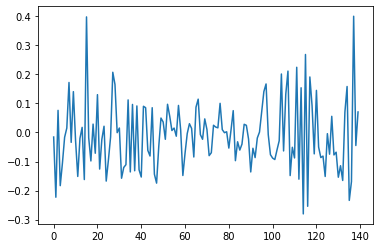

In [65]:
#plt.plot(particle.x)
plt.plot(np.diff(particle.x))
plt.show()

In [66]:
diff = np.diff(particle.x)
N = len(diff)
varN = np.var(diff)
estimator = []

for k in range(2, len(diff)-2):
    vark = np.var(diff[:k])
    varkN = np.var(diff[k:])

    L = N*np.log(varN) - k*np.log(vark) - (N-k)*np.log(varkN)
    estimator.append(L)
    print(f"{k}: {L:.2f}")

2: 1.83
3: 0.47
4: 1.78
5: 2.49
6: 2.28
7: 1.88
8: 0.43
9: 0.44
10: 0.08
11: 0.06
12: 0.36
13: 0.41
14: 0.41
15: 0.83
16: 2.77
17: 2.23
18: 1.98
19: 1.57
20: 1.29
21: 1.39
22: 1.34
23: 1.01
24: 0.73
25: 1.02
26: 1.00
27: 0.77
28: 1.12
29: 1.48
30: 1.17
31: 0.92
32: 0.99
33: 0.98
34: 0.99
35: 0.90
36: 1.02
37: 0.88
38: 0.99
39: 0.83
40: 0.93
41: 1.25
42: 1.02
43: 0.83
44: 0.71
45: 0.69
46: 0.51
47: 0.73
48: 1.21
49: 1.14
50: 0.89
51: 0.68
52: 0.61
53: 0.40
54: 0.25
55: 0.19
56: 0.14
57: 0.16
58: 0.07
59: 0.11
60: 0.21
61: 0.33
62: 0.41
63: 0.46
64: 0.56
65: 0.76
66: 0.69
67: 0.57
68: 0.76
69: 0.98
70: 1.14
71: 1.39
72: 1.61
73: 1.87
74: 2.15
75: 2.48
76: 2.83
77: 2.86
78: 3.27
79: 3.71
80: 4.19
81: 4.61
82: 5.13
83: 5.42
84: 5.64
85: 6.21
86: 6.71
87: 7.31
88: 7.90
89: 8.54
90: 9.25
91: 9.19
92: 9.87
93: 10.39
94: 11.20
95: 12.01
96: 12.42
97: 11.85
98: 10.92
99: 11.76
100: 12.33
101: 12.84
102: 13.34
103: 14.14
104: 15.11
105: 13.19
106: 13.96
107: 13.71
108: 11.95
109: 11.56
110: 12.3

In [67]:
def horc(N, alpha=0.01):
    b_n = 2*np.log(np.log(N)) + np.log(np.log(np.log(N)))
    a_n = np.sqrt(2*np.log(np.log(N)))
    c = (b_n - np.log(-np.log(1-alpha))) / a_n
    
    return c

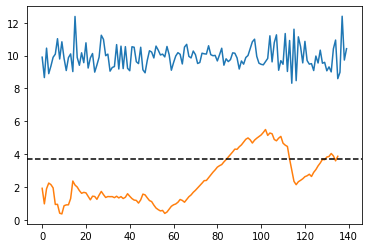

In [70]:
plt.plot(10+diff*6)
plt.plot(np.sqrt(np.multiply(estimator, 2)))
plt.axhline(horc(N, alpha=0.05), linestyle='--', color='k')
plt.show()